**VEHICLE TYPE CLASSIFICATION**

In [1]:
!pip install tensorflow gdown opencv-python matplotlib numpy scikit-learn

In [3]:
import gdown, zipfile
import os
import shutil

# Google Drive file ID (your new zip)
file_id = "1NkLlTDQ6kWOG4s-gjNyoBLP7yi1n6Yji"
url = f"https://drive.google.com/uc?id={file_id}"

# Download zip file
gdown.download(url, "archive.zip", quiet=False)

# Extract zip
with zipfile.ZipFile("archive.zip", "r") as z:
    z.extractall(".")

# Ensure target directory exists
os.makedirs("dataset", exist_ok=True)

# Move the Dataset folder into dataset/vehicles
if os.path.exists("Dataset"):
    if os.path.exists("dataset/vehicles"):
        shutil.rmtree("dataset/vehicles")
    shutil.move("Dataset", "dataset/vehicles")
else:
    print("❌ ERROR: 'Dataset' folder not found inside ZIP!")

print("✅ Dataset is ready!")


Downloading...
From (original): https://drive.google.com/uc?id=1NkLlTDQ6kWOG4s-gjNyoBLP7yi1n6Yji
From (redirected): https://drive.google.com/uc?id=1NkLlTDQ6kWOG4s-gjNyoBLP7yi1n6Yji&confirm=t&uuid=4c35e5ba-ea6a-47a9-862d-717f886b92c0
To: /content/archive.zip
100%|██████████| 166M/166M [00:04<00:00, 41.1MB/s]


✅ Dataset is ready!


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [6]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=30,
    zoom_range=0.25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True
)

train_data = train_gen.flow_from_directory(
    "dataset/vehicles",
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = train_gen.flow_from_directory(
    "dataset/vehicles",
    target_size=(224, 224),
    batch_size=16,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)


Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [7]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # freeze first training phase


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.4)(x)

output = tf.keras.layers.Dense(4, activation="softmax")(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0008),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,586,948 (9.87 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
history1 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=12
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
14/20 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.3512 - loss: 1.6445

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 39s 982ms/step - accuracy: 0.4263 - loss: 1.4477 - val_accuracy: 0.9625 - val_loss: 0.1651
Epoch 2/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 714ms/step - accuracy: 0.8797 - loss: 0.3322 - val_accuracy: 0.9500 - val_loss: 0.1720
Epoch 3/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 721ms/step - accuracy: 0.9136 - loss: 0.2434 - val_accuracy: 0.9375 - val_loss: 0.1709
Epoch 4/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 700ms/step - accuracy: 0.9380 - loss: 0.1863 - val_accuracy: 0.9750 - val_loss: 0.0976
Epoch 5/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 759ms/step - accuracy: 0.8851 - loss: 0.2557 - val_accuracy: 0.9750 - val_loss: 0.0844
Epoch 6/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 701ms/step - accuracy: 0.9703 - loss: 0.1564 - val_accuracy: 0.9375 - val_loss: 0.1264
Epoch 7/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 676ms/step - accuracy: 0.9339 - loss: 0.1540 - val_accuracy: 0.9625 - val_loss: 0.1529
Epoch 8/12
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 730ms/step - accuracy: 0.9281 - loss: 0.1820 - val_accuracy: 0.950

In [10]:
for layer in base_model.layers[-40:]:
    layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10
)


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.7960 - loss: 0.4376 - val_accuracy: 0.9500 - val_loss: 0.1123
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 731ms/step - accuracy: 0.8899 - loss: 0.2594 - val_accuracy: 0.9625 - val_loss: 0.0989
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 700ms/step - accuracy: 0.8974 - loss: 0.2211 - val_accuracy: 0.9375 - val_loss: 0.1623
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 731ms/step - accuracy: 0.9320 - loss: 0.2223 - val_accuracy: 0.9250 - val_loss: 0.1115
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 19s 969ms/step - accuracy: 0.9627 - loss: 0.1281 - val_accuracy: 0.9625 - val_loss: 0.0806
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 852ms/step - accuracy: 0.9381 - loss: 0.1859 - val_accuracy: 0.9500 - val_loss: 0.1468
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9780 - loss: 0.0872 - val_accuracy: 0.9375 - val_loss: 0.1451
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 787ms/step - accuracy: 0.9376 - loss: 0.1358 - val_accuracy: 

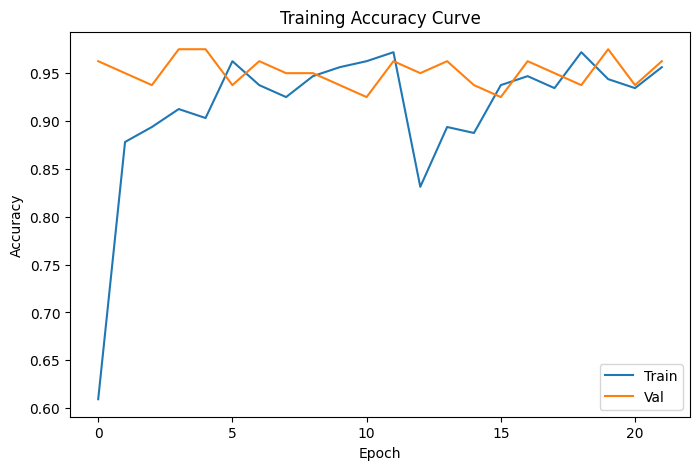

In [11]:
plt.figure(figsize=(8,5))
plt.plot(history1.history['accuracy'] + history2.history['accuracy'])
plt.plot(history1.history['val_accuracy'] + history2.history['val_accuracy'])
plt.title("Training Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"])
plt.show()


In [12]:
model.save("vehicle_classifier_best.h5")
print("✅ Model saved successfully!")


✅ Model saved successfully!


5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 406ms/step


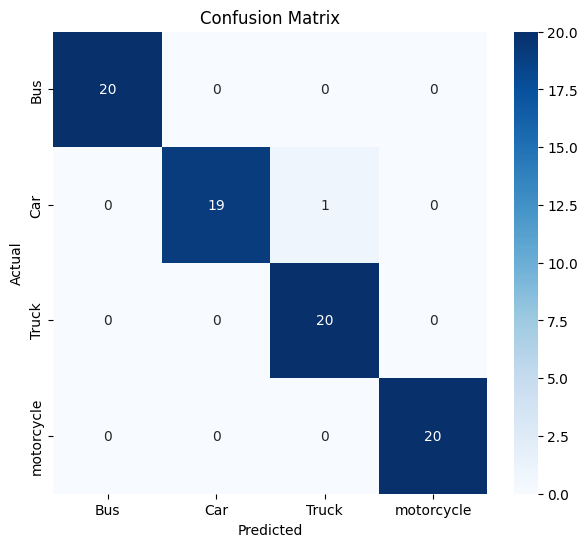


Classification Report:
              precision    recall  f1-score   support

         Bus       1.00      1.00      1.00        20
         Car       1.00      0.95      0.97        20
       Truck       0.95      1.00      0.98        20
  motorcycle       1.00      1.00      1.00        20

    accuracy                           0.99        80
   macro avg       0.99      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



In [13]:
val_data.shuffle = False
pred = model.predict(val_data)

y_pred = np.argmax(pred, axis=1)
y_true = val_data.classes

labels = list(val_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


In [15]:
from tensorflow.keras.preprocessing import image

labels = list(val_data.class_indices.keys())

def predict_vehicle(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array)
    class_id = np.argmax(pred)

    print("Predicted Vehicle Type:", labels[class_id])


In [20]:
from google.colab import files
uploaded = files.upload()

filename = list(uploaded.keys())[0]
print("Detected file:", filename)

predict_vehicle(filename)


Saving Image_2.jpg to Image_2.jpg
Detected file: Image_2.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted Vehicle Type: Truck
